In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
import joblib
import os
from tqdm import tqdm
from dataloader import get_dataloaders

In [31]:
# Define Neural Network
class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, input_dim)
        self.bn = nn.BatchNorm1d(input_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.fc(x)
        out = self.bn(out)
        out = self.relu(out)
        return out + residual

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.res_block = ResidualBlock(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.res_block(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [32]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5):
    best_val_loss = float("inf")
    early_stop_counter = 0
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
        
        # Early Stopping & Model Saving
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            os.makedirs("./models", exist_ok=True)
            torch.save(model.state_dict(), "./models/best_neural_model.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
    
    return train_losses, val_losses

In [33]:
# Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [42]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, name):
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes)
    plt.title(f"Neural Network Confusion Matrix - {name}")
    plt.show()

In [43]:
# Plot ROC Curve
def plot_roc_curve(y_true, y_scores, classes, name):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Neural Network ROC Curve - {name}")
    plt.legend()
    plt.show()


In [36]:
# Dataloader
structural_csv = "./data/merged/processed_urls.csv"
embeddings_csv = "./data/merged/url_embeddings.csv"
train_loader, val_loader, test_loader = get_dataloaders(structural_csv, embeddings_csv, merge_embeddings=True)

In [37]:
# Define Model
input_dim = next(iter(train_loader))[0].shape[1]
num_classes = len(set(next(iter(train_loader))[1].numpy()))
model = NeuralNetwork(input_dim, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NeuralNetwork(
  (fc1): Linear(in_features=779, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block): ResidualBlock(
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [38]:
# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)

Epoch 1/50: 100%|██████████| 1491/1491 [00:44<00:00, 33.48it/s]


Epoch 1: Train Loss = 0.3111, Val Loss = 0.4458


Epoch 2/50: 100%|██████████| 1491/1491 [00:42<00:00, 34.79it/s]


Epoch 2: Train Loss = 0.1967, Val Loss = 0.1965


Epoch 3/50: 100%|██████████| 1491/1491 [00:43<00:00, 34.50it/s]


Epoch 3: Train Loss = 0.1662, Val Loss = 0.1524


Epoch 4/50: 100%|██████████| 1491/1491 [00:43<00:00, 34.62it/s]


Epoch 4: Train Loss = 0.1494, Val Loss = 0.1583


Epoch 5/50: 100%|██████████| 1491/1491 [00:45<00:00, 33.13it/s]


Epoch 5: Train Loss = 0.1365, Val Loss = 0.1574


Epoch 6/50: 100%|██████████| 1491/1491 [00:46<00:00, 32.07it/s]


Epoch 6: Train Loss = 0.1216, Val Loss = 0.1545


Epoch 7/50: 100%|██████████| 1491/1491 [00:46<00:00, 31.73it/s]


Epoch 7: Train Loss = 0.1145, Val Loss = 0.1715


Epoch 8/50: 100%|██████████| 1491/1491 [00:49<00:00, 30.27it/s]


Epoch 8: Train Loss = 0.1079, Val Loss = 0.1349


Epoch 9/50: 100%|██████████| 1491/1491 [00:45<00:00, 33.13it/s]


Epoch 9: Train Loss = 0.0995, Val Loss = 0.1544


Epoch 10/50: 100%|██████████| 1491/1491 [00:45<00:00, 32.56it/s]


Epoch 10: Train Loss = 0.0948, Val Loss = 0.1289


Epoch 11/50: 100%|██████████| 1491/1491 [00:43<00:00, 34.58it/s]


Epoch 11: Train Loss = 0.0870, Val Loss = 0.1341


Epoch 12/50: 100%|██████████| 1491/1491 [00:48<00:00, 30.85it/s]


Epoch 12: Train Loss = 0.0849, Val Loss = 0.1406


Epoch 13/50: 100%|██████████| 1491/1491 [00:44<00:00, 33.21it/s]


Epoch 13: Train Loss = 0.0794, Val Loss = 0.1365


Epoch 14/50: 100%|██████████| 1491/1491 [00:45<00:00, 33.00it/s]


Epoch 14: Train Loss = 0.0749, Val Loss = 0.1378


Epoch 15/50: 100%|██████████| 1491/1491 [00:43<00:00, 34.16it/s]


Epoch 15: Train Loss = 0.0746, Val Loss = 0.1416
Early stopping triggered.


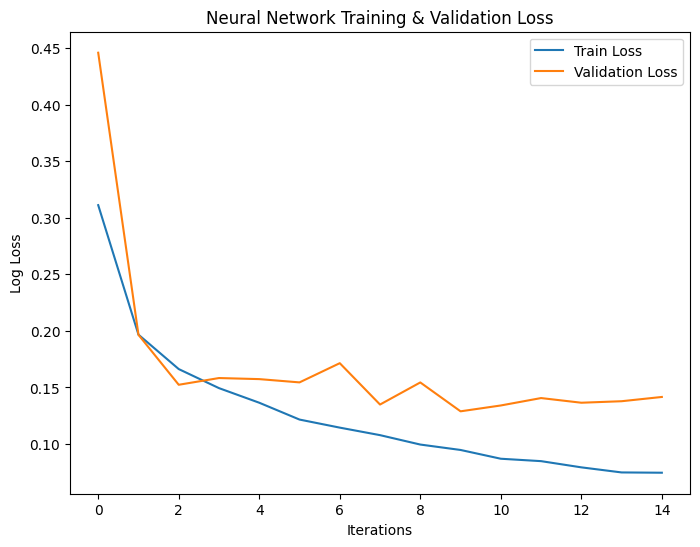

In [44]:
# ========== PLOT TRAINING LOSS ==========

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Neural Network Training & Validation Loss")
plt.show()

In [45]:
 # Load Best Model
model.load_state_dict(torch.load("./models/best_neural_model.pth"))

C:\Users\sarim\AppData\Local\Temp\ipykernel_31220\264553289.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./models/best_neural_model.

<All keys matched successfully>


📊 Neural Network Classification Report for Train:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97      9553
  defacement       0.99      0.99      0.99      9571
     malware       0.99      0.96      0.97      9483
    phishing       0.94      0.96      0.95      9632
        spam       1.00      1.00      1.00      9446

    accuracy                           0.98     47685
   macro avg       0.98      0.98      0.98     47685
weighted avg       0.98      0.98      0.98     47685



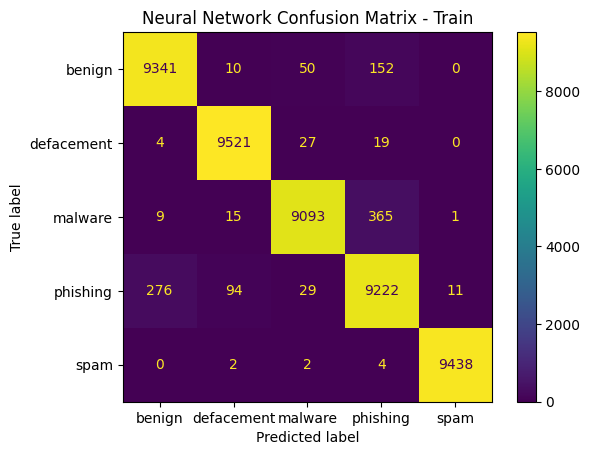

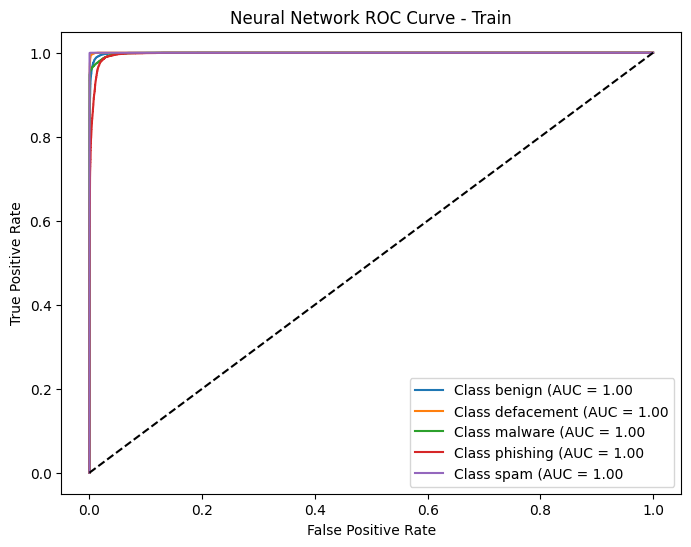


📊 Neural Network Classification Report for Val:
              precision    recall  f1-score   support

      benign       0.95      0.96      0.95      1172
  defacement       0.96      0.98      0.97      1188
     malware       0.98      0.94      0.96      1241
    phishing       0.91      0.91      0.91      1127
        spam       1.00      1.00      1.00      1232

    accuracy                           0.96      5960
   macro avg       0.96      0.96      0.96      5960
weighted avg       0.96      0.96      0.96      5960



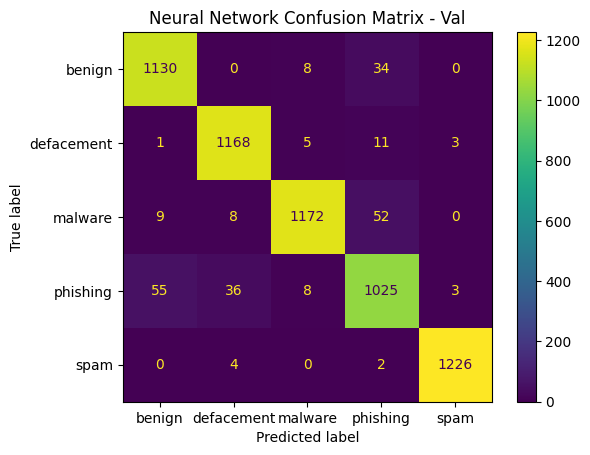

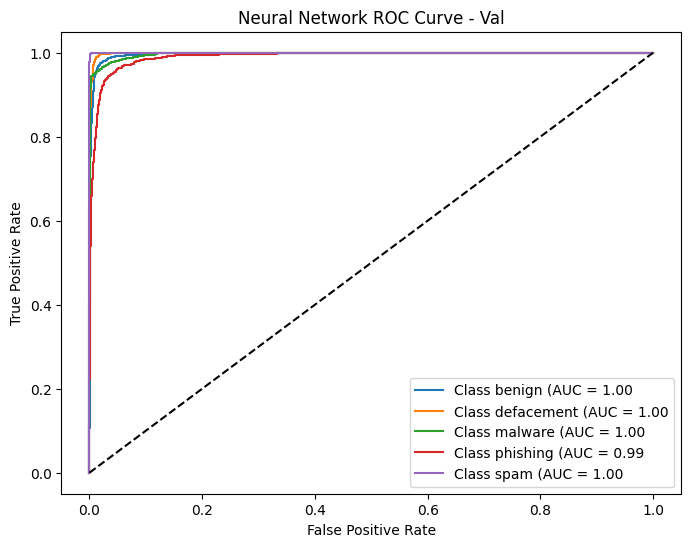


📊 Neural Network Classification Report for Test:
              precision    recall  f1-score   support

      benign       0.95      0.95      0.95      1196
  defacement       0.98      0.99      0.98      1162
     malware       0.98      0.95      0.96      1197
    phishing       0.91      0.92      0.91      1162
        spam       1.00      1.00      1.00      1243

    accuracy                           0.96      5960
   macro avg       0.96      0.96      0.96      5960
weighted avg       0.96      0.96      0.96      5960



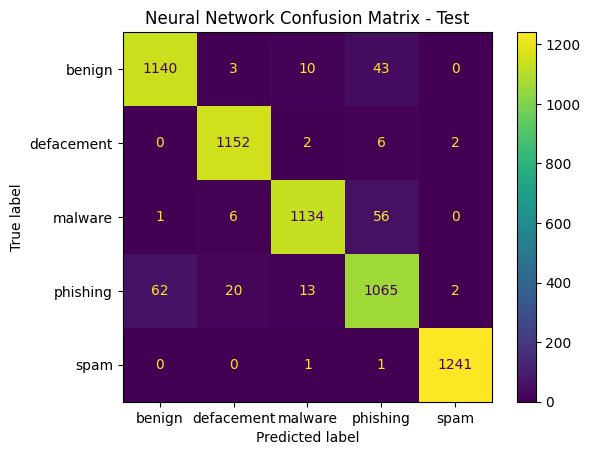

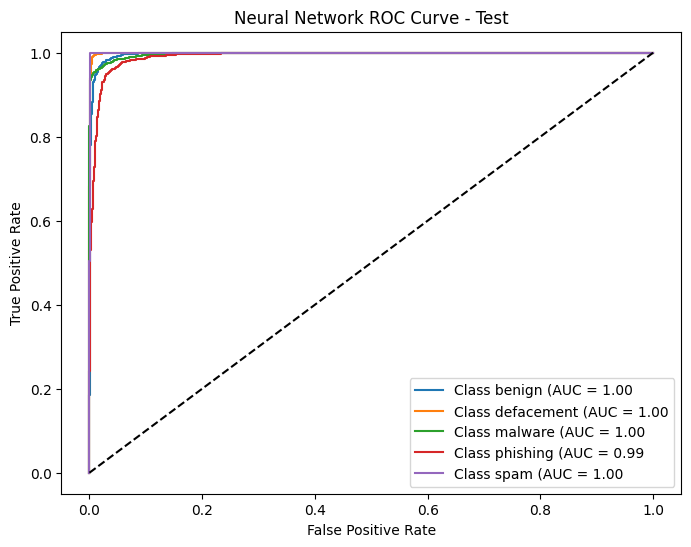

In [ ]:
loaders = { "Train" : train_loader, "Val" : val_loader, "Test" : test_loader }
label_mapping = {0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}

for name, loader in loaders.items():
    
    # Evaluate on Test Set
    y_true, y_pred, y_scores = evaluate_model(model, loader, device)

    class_names = list(label_mapping.values())

    print(f"\n📊 Neural Network Classification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, class_names, name)
    
    # Plot ROC Curve
    plot_roc_curve(y_true, y_scores, class_names, name)